In [2]:
import os
import math
import json
import datetime
import numpy as np

from tifffile import tifffile

from skimage import morphology, filters, transform, measure
from skimage.feature import peak_local_max

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import cm

from scipy import stats, optimize
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.ndimage import center_of_mass

def plane(X, a, b, c):
    return(a*X[0] + b * X[1] + c)


def delayed_exponential_on(t, b, tau, upper_lim, lower_lim):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b*(t - tau))
    de[t < tau] = lower_lim
    return(de)


def delayed_exponential_on_off(t, b_on, b_off, tau_on, tau_off, upper_lim, lower_lim, lower_lim2):
    de = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(t - tau_on))
    de[t < tau_on] = lower_lim
    
    val = upper_lim - (upper_lim - lower_lim) * np.exp(b_on*(tau_off - tau_on))
    de[t > tau_off] =  lower_lim2 + (val - lower_lim2) * np.exp(b_off*(t[t > tau_off] - tau_off))
    return(de)

class simpleStimData:
    
    def __init__(self, folderpath):
        self.folderpath = folderpath
        self.xpath_rot = []
        self.ypath_rot = []
        self.assay_type = ''
        self.get_image_paths()
        self.get_stage_data()
        self.transform_mats = self.get_transformation_matrices()
        self.get_image_stacks()
        self.background_subtraction()
        
    def get_image_paths(self):
        
        # collect image paths within the folder
        try:
            im_path_list = np.sort([self.folderpath + '/' + i for i in np.sort(os.listdir(self.folderpath))])
        except:
            im_path_list = np.sort([self.folderpath + '/' + i.decode('ascii') for i in np.sort(os.listdir(self.folderpath))])

        self.ch0_path_list = np.sort([i for i in im_path_list if 'channel000' in i])
        self.ch1_path_list = np.sort([i for i in im_path_list if 'channel001' in i])
        self.ch2_path_list = np.sort([i for i in im_path_list if 'channel002' in i])
        self.ch3_path_list = np.sort([i for i in im_path_list if 'channel003' in i])
        self.ch4_path_list = np.sort([i for i in im_path_list if 'channel004' in i])
        self.ch5_path_list = np.sort([i for i in im_path_list if 'channel005' in i])
        self.ch6_path_list = np.sort([i for i in im_path_list if 'channel006' in i])
        
    def get_stage_data(self):
        
        x_stage_sequence = []
        y_stage_sequence = []

        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:

                # collect stage coordinates from tiff metadata
                xval = float(temptif.shaped_metadata[0]['stage_x_pos'])
                yval = float(temptif.shaped_metadata[0]['stage_y_pos'])

                x_stage_sequence.append(xval)
                y_stage_sequence.append(yval)

        # convert to numpy arrays to make translation and rotation a little easier
        self.x_stage_sequence = np.array(x_stage_sequence)
        self.y_stage_sequence = np.array(y_stage_sequence)

        # center paths on the moment of stimulation
        x_translated = self.x_stage_sequence - self.x_stage_sequence[10] 
        y_translated = self.y_stage_sequence - self.y_stage_sequence[10]

        # calculate the initial direction of the cell in the first ten frames
        self.theta = np.arctan2(-np.average(np.diff(y_translated[:10])), np.average(np.diff(x_translated[:10])))

        # convert into 
        rho = np.hypot(x_translated, y_translated)
        phi = np.arctan2(-y_translated, x_translated) - self.theta  + math.pi/2

        self.x_rotated = rho * np.cos(phi)
        self.y_rotated = rho * np.sin(phi)
        self.centering_x = self.x_stage_sequence[10]
        self.centering_y = self.y_stage_sequence[10]
        

    def get_transformation_matrices(self):
        
        temptif = tifffile.TiffFile(self.ch0_path_list[0])
        centering_matrix = np.array([[1, 0, -200],[0, 1, -200],[0, 0, 1]])
        affine_matrix = np.vstack([np.array([float(i) for i in temptif.shaped_metadata[0]['PixelSizeAffine'].split(';')]).reshape(2, 3), np.array([0, 0, 1])])
        rotation_matrix = np.array([[np.cos(self.theta), -np.sin(self.theta), 0], [np.sin(self.theta), np.cos(self.theta), 0], [0, 0, 1]])
        transformation_matrix = np.matmul(affine_matrix, centering_matrix)
        transformation_matrix = np.matmul(rotation_matrix, transformation_matrix)


        transformation_matrices = []
        for t in range(len(self.x_stage_sequence)):

            xt = (self.x_stage_sequence[t] - self.centering_x)
            yt = (self.y_stage_sequence[t] - self.centering_y)

            xr, yr, placeholder = np.matmul(rotation_matrix, np.array([xt, yt, 0]))
            translation_matrix = np.array([[1, 0, xr],[0, 1, yr],[0, 0, 1]])

            tm = np.matmul(translation_matrix, transformation_matrix)

            transformation_matrices.append(tm.copy())

        return(transformation_matrices)

        
    def get_image_stacks(self):
        
        # make some containers for the pixel intensity information
        self.ch0_stack = np.zeros((len(self.ch0_path_list), 400, 400))
        self.ch1_stack = np.zeros((len(self.ch1_path_list), 400, 400))
        self.ch2_stack = np.zeros((len(self.ch2_path_list), 400, 400))
        self.ch3_stack = np.zeros((len(self.ch3_path_list), 400, 400))
        self.ch4_stack = np.zeros((len(self.ch4_path_list), 400, 400))
        self.ch5_stack = np.zeros((len(self.ch5_path_list), 400, 400))
        self.ch6_stack = np.zeros((len(self.ch6_path_list), 400, 400))
        
        # and for elapsed time
        self.ch0_times = np.zeros(len(self.ch0_path_list))
        self.ch1_times = np.zeros(len(self.ch1_path_list))
        self.ch2_times = np.zeros(len(self.ch2_path_list))
        self.ch3_times = np.zeros(len(self.ch3_path_list))
        self.ch4_times = np.zeros(len(self.ch4_path_list))
        self.ch5_times = np.zeros(len(self.ch5_path_list))
        self.ch6_times = np.zeros(len(self.ch6_path_list))
        
        for i in range(len(self.ch0_path_list)):
            with tifffile.TiffFile(self.ch0_path_list[i]) as temptif:
                self.ch0_stack[i] = temptif.asarray()
                try:
                    self.ch0_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass

        for i in range(len(self.ch1_path_list)):
            with tifffile.TiffFile(self.ch1_path_list[i]) as temptif:
                self.ch1_stack[i] = temptif.asarray()
                try:
                    self.ch1_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch2_path_list)):
            with tifffile.TiffFile(self.ch2_path_list[i]) as temptif:
                self.ch2_stack[i] = temptif.asarray()
                try:
                    self.ch2_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch3_path_list)):
            with tifffile.TiffFile(self.ch3_path_list[i]) as temptif:
                self.ch3_stack[i] = temptif.asarray()
                try:
                    self.ch3_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch4_path_list)):
            with tifffile.TiffFile(self.ch4_path_list[i]) as temptif:
                self.ch4_stack[i] = temptif.asarray()
                try:
                    self.ch4_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch5_path_list)):
            with tifffile.TiffFile(self.ch5_path_list[i]) as temptif:
                self.ch5_stack[i] = temptif.asarray()
                try:
                    self.ch5_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
                
        for i in range(len(self.ch6_path_list)):
            with tifffile.TiffFile(self.ch6_path_list[i]) as temptif:
                self.ch6_stack[i] = temptif.asarray()
                try:
                    self.ch6_times[i] = np.round(float(temptif.shaped_metadata[0]['elapsed_time_s']), 1)
                except:
                    pass
        
    def generate_time_trace_plot(self):
        fig, ax = plt.subplots(2, 1, figsize=(10,10), gridspec_kw = {'height_ratios': [10, 1]}, subplot_kw = {'aspect': 1} )

        cmap = cm.get_cmap('viridis')
        col_vec = [cmap(i) for i in np.linspace(0, 1, len(self.ch3_stack))]
        for i in range(len(self.ch3_stack)):
            contours = measure.find_contours(self.ch3_stack[i] > 0, level = False)
            mat = self.transform_mats[i]

            for ctr in contours:
                y_pixel, x_pixel = ctr.T
                placeholder = np.ones_like(x_pixel)

                ctr_px = np.array([x_pixel, y_pixel, placeholder])

                y_um, x_um, placeholder = np.matmul(mat, ctr_px)
                ax[0].plot(x_um, y_um, color = col_vec[i], alpha = 0.9, zorder = 1)



        plt.plot(self.x_rotated, self.y_rotated, color = 'k', zorder = 0)
        ax[0].axis([-100, 100, -80, 120])

        ax[1].set_aspect(10)
        norm = mpl.colors.Normalize(vmin = 0, vmax = self.ch0_times[-1])

        cb1 = mpl.colorbar.ColorbarBase(ax[1], cmap=cmap,norm=norm,orientation='horizontal')
        cb1.set_label('Elapsed Time (s)')
        plt.tight_layout()

        plt.show()
        
    def get_transformed_xy_coords(self, timepoint):
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz = np.ones_like(xx)

        coords = np.array([xx.ravel(), yy.ravel(), zz.ravel()])
        y_um, x_um, placeholder = np.matmul(self.transform_mats[timepoint], coords)
        
        return(x_um.reshape(400,400), y_um.reshape(400,400))

    
    def background_subtraction(self):
        # fit a plane to the median of non-cell signal over the course of the experiment
        bgstack_ch0 = []
        bgstack_ch1 = []
        for T in range(len(self.ch0_stack)):
            bg_ch0 = self.ch0_stack[T].copy()
            bg_ch1 = self.ch1_stack[T].copy()
            cell = self.ch3_stack[T] == 1
            cell = morphology.binary_dilation(cell, selem = morphology.disk(10))
            bg_ch0[cell] = np.nan
            bg_ch1[cell] = np.nan
            bgstack_ch0.append(bg_ch0)
            bgstack_ch1.append(bg_ch1)

        measured_bg_ch0 = np.nanmedian(bgstack_ch0, axis = 0)
        measured_bg_ch1 = np.nanmedian(bgstack_ch1, axis = 0)
        xx, yy = np.meshgrid(np.arange(400), np.arange(400))
        zz_ch0 = measured_bg_ch0
        zz_ch1 = measured_bg_ch1

        xx = xx[np.isfinite(zz_ch0)]
        yy = yy[np.isfinite(zz_ch0)]
        zz_ch0 = zz_ch0[np.isfinite(zz_ch0)]
        zz_ch1 = zz_ch1[np.isfinite(zz_ch1)]

        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(plane, X, zz_ch0, p0 = [1, 1, 500])
        popt_ch1, pcov = optimize.curve_fit(plane, X, zz_ch1, p0 = [1, 1, 500])
        
        X = np.meshgrid(np.arange(400), np.arange(400))
        self.ch0_estimated_bg = plane(X, popt_ch0[0], popt_ch0[1], popt_ch0[2])
        self.ch1_estimated_bg = plane(X, popt_ch1[0], popt_ch1[1], popt_ch1[2])
    
    def calculate_global_dynamics(self):
        ch0_avg = []
        ch1_avg = []
        
        for T in range(len(self.ch0_stack)):
            try:
                ch0_F = np.average((self.ch0_stack[T] - self.ch0_estimated_bg)[self.ch3_stack[T] > 0])
                ch1_F = np.average((self.ch1_stack[T] - self.ch1_estimated_bg)[self.ch3_stack[T] > 0])
                
            except:
                ch0_F = np.nan
                ch1_F = np.nan
                
            ch0_avg.append(ch0_F)
            ch1_avg.append(ch1_F)
            
        self.ch0_dynamics = np.array(ch0_avg)
        self.ch1_dynamics = np.array(ch1_avg)
        
    def calculate_frontbackSignals(self):
        ch0_frontback = []
        ch1_frontback = []

        for T in range(len(self.ch0_stack)):

            try:
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                xx -= 200
                yy -= 200

                regions = measure.regionprops((self.ch3_stack[T] > 0).astype(int), intensity_image = self.ch1_stack[T] - self.ch1_estimated_bg)
                yc, xc = regions[0].centroid
                yw, xw = regions[0].weighted_centroid
                direction = np.arctan2(yw - yc, xw - xc)

                dist = np.hypot(xx, yy)
                angle = np.arctan2(yy, xx)
                dmap = dist * np.cos(angle - direction)
                dmap[self.ch3_stack[T] == 0] = np.nan

                frontloc = np.unravel_index(np.nanargmax(dmap), dmap.shape)
                xx, yy = np.meshgrid(np.arange(400), np.arange(400))
                dmap2 = np.hypot(yy - frontloc[0], xx - frontloc[1])
                x, y = dmap2[self.ch3_stack[T] > 0], self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                bs, be, bn = stats.binned_statistic(x, y, statistic = 'mean', bins = np.arange(0, 101))

                y2 = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                bs2, be, bn = stats.binned_statistic(x, y2, statistic = 'mean', bins = np.arange(0, 101))

            except:
                bs = np.zeros(100) + np.nan
                bs2 = np.zeros(100) + np.nan

            ch0_frontback.append(bs)
            ch1_frontback.append(bs2)
            
        self.ch0_frontback = ch0_frontback
        self.ch1_frontback = ch1_frontback
        
        
    def get_angular_representation(self):
        
        self.ch0_ring = []
        self.ch1_ring = []
        self.ch2_ring = []
        
        self.ringstack = []

        pixch0 = []
        pixch1 = []
        for T in range(10):
            if np.sum(self.ch3_stack[T]) > 0:
                vals = self.ch0_stack[T][self.ch3_stack[T] > 0] - self.ch0_estimated_bg[self.ch3_stack[T] > 0]
                pixch0 = np.hstack([pixch0, vals])
                vals = self.ch1_stack[T][self.ch3_stack[T] > 0] - self.ch1_estimated_bg[self.ch3_stack[T] > 0]
                pixch1 = np.hstack([pixch1, vals])
        ch0_basal = np.average(pixch0)
        ch1_basal = np.average(pixch1)


        for T in range(len(self.ch3_stack)):
            
            if np.sum(self.ch3_stack[T]) > 0:
                outer = self.ch3_stack[T] > 0

                inner = morphology.binary_erosion(outer, selem = morphology.disk(15))
                ring = morphology.binary_erosion(outer, selem = morphology.disk(1)) & ~inner

                self.ringstack.append(ring)

                yc, xc = center_of_mass(self.ch3_stack[T])

                yy, xx = np.where(ring)
                A = np.arctan2(-(yy - yc), (xx - xc)) + self.theta
                A = np.arctan2(-np.sin(A), np.cos(A))

                F = self.ch0_stack[T][ring] - self.ch0_estimated_bg[ring]
                F /= ch0_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch0_ring.append(bs)

                F = self.ch1_stack[T][ring] - self.ch1_estimated_bg[ring]
                F /= ch1_basal
                bs, be, bn = stats.binned_statistic(A, F, statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch1_ring.append(bs)

                bs, be, bn = stats.binned_statistic(A, self.ch2_stack[T][ring], statistic = 'mean', bins = np.linspace(-math.pi, math.pi, 101))
                self.ch2_ring.append(bs)

            else:
                self.ch0_ring.append(np.zeros(100) + np.nan)
                self.ch1_ring.append(np.zeros(100) + np.nan)
                self.ch2_ring.append(np.zeros(100) + np.nan)
                
        
class mm_microscope_image:
    def __init__(self, path):
        self.filepath = path
        self.array = None
        self.framenumber = None
        self.elapsed_time_s = None
        self.channel = None
        self.pixelsizeum = None
        self.md = None
        self.H = None
        self.W = None

        with tifffile.TiffFile(path) as tif:
            try:
                md = json.loads(tif.imagej_metadata["Info"])
                self.md = md
                self.array = tif.asarray()
                self.framenumber = None
                self.elapsed_time_s = md['ElapsedTime-ms']/1000.
                self.channel = None
                try:
                    self.pixelsizeum = md['PixelSize_um']
                except:
                    self.pixelsizeum = md['PixelSizeUm']
                self.H = md['Width']
                self.W = md['Height']
                self.stage_x = md['XPositionUm']
                self.stage_y = md['YPositionUm']
            except:
                self.md = tif.shaped_metadata[0]
                self.array = tif.asarray()
                self.framenumber = None
                self.channel = None
                self.H, self.W = self.md['shape']
                try:
                    self.elapsed_time_s = float(self.md['elapsed_time_s'])
                    self.pixelsizeum = self.md['PixelSizeUm']
                except:
                    pass
                try:
                    self.stage_x = self.md['stage_x_pos']
                    self.stage_y = self.md['stage_y_pos']
                except:
                    pass
    
class led_metadata:
    def __init__(self, path):
        self.filepath = path
        
        
        with open(self.filepath) as f:
            lines = f.readlines()
            summary = lines[0]
            data = lines[1:]

            timestamps = []
            intensities = []

            for i in data:
                timestamp, setstring = i.strip().split('\t')

                intensity = setstring.split(' ')[-1]

                timestamps.append(datetime.datetime.strptime(timestamp, '%Y-%m-%d %H:%M:%S.%f'))
                intensities.append(int(intensity))
            
            self.timepoints = np.array(timestamps)
            self.ledvalues = np.array(intensities)
            
def twoDQuadFunc(X, a, b, c, d, e, f):
    return(a*X[0]**2 + b*X[0]*X[1] + c*X[1]**2 + d*X[0] + e*X[1] + f)

class mm_acquisition:
    
    def __init__(self, acq_path):
        
        self.acq_path = acq_path
        self.microscope_image_list = []
        
        try:
            with open(acq_path + '/metadata.txt', "r") as read_file:
                self.acq_mdata = json.load(read_file)
        except:
            pass
        
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S.%f')
        except:
            pass
        try:
            self.start_time = datetime.datetime.strptime(self.acq_mdata['Summary']['StartTime'][:-6], '%Y-%m-%d %H:%M:%S')
        except:
            pass
        
        try:
            self.led_data = led_metadata(acq_path + '/intensities.txt')
            self.led_timepoints_sec = [(t - self.start_time).total_seconds() for t in self.led_data.timepoints]
        except:
            print("Problem with LED metadata")
            
        for i in np.sort(os.listdir(self.acq_path)):
            try:
                i = i.decode()
            except:
                pass
            
            if '.tif' in i:
                img_obj = mm_microscope_image(self.acq_path + '/' + i)
                
                try:
                    name_fragments = i.split('_')
                    img_obj.framenumber = int(name_fragments[3][4:])
                    img_obj.channel = int(name_fragments[1][7:])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-Default/' + i]['Frame'])
                    img_obj.channel = int(self.acq_mdata['Coords-Default/' + i]['ChannelIndex'])
                except:
                    pass
                
                try:
                    img_obj.framenumber = int(self.acq_mdata['Coords-' + i]['time'])
                    img_obj.channel = int(self.acq_mdata['Coords-' + i]['channel'])
                except:
                    pass
                
                    
                self.microscope_image_list.append(img_obj)

        self.channels = np.array([m.channel for m in self.microscope_image_list])
        self.framenumbers = np.array([m.framenumber for m in self.microscope_image_list])
        self.elapsedtimes = np.array([m.elapsed_time_s for m in self.microscope_image_list])
        
        imstack = np.array([m.array for m in self.microscope_image_list])
        
        self.ch0_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch1_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        self.ch2_stack = np.zeros((np.max(self.framenumbers) + 1, self.microscope_image_list[0].H, self.microscope_image_list[0].W))
        
        for i in self.microscope_image_list:
            if i.channel == 0:
                self.ch0_stack[i.framenumber] = i.array
            if i.channel == 1:
                self.ch1_stack[i.framenumber] = i.array
            if i.channel == 2:
                self.ch2_stack[i.framenumber] = i.array

                
        self.estimate_background()
        self.estimate_stationary_single_cell_signals()
        
    def estimate_background(self):
        img = np.median(self.ch0_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        
        h, w = background.shape
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch0_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch0_stack_bgcorrected = np.array([i.astype(float) - self.ch0_estimated_bg for i in self.ch0_stack])

        img = np.median(self.ch1_stack, axis = 0)
        smth1 = filters.gaussian(img, 3, preserve_range = True)
        smth2 = filters.gaussian(img, 30, preserve_range = True)
        DoG = smth1 - smth2
        foreground = DoG > 0
        foreground = morphology.binary_dilation(foreground, selem = morphology.disk(20))
        background = img.copy().astype(float)
        background[foreground] = np.nan
        xx, yy = np.meshgrid(np.arange(h), np.arange(w))
        zz_ch0 = background
        xx = xx[np.isfinite(background)]
        yy = yy[np.isfinite(background)]
        zz_ch0 = zz_ch0[np.isfinite(background)]
        X = np.array([xx, yy])
        popt_ch0, pcov = optimize.curve_fit(twoDQuadFunc, X, zz_ch0, p0 = [1, 1, 1, 1, 1, 500])
        X = np.meshgrid(np.arange(h), np.arange(w))
        self.ch1_estimated_bg = twoDQuadFunc(X, popt_ch0[0], popt_ch0[1], popt_ch0[2], popt_ch0[3], popt_ch0[4], popt_ch0[5])
        self.ch1_stack_bgcorrected = np.array([i.astype(float) - self.ch1_estimated_bg for i in self.ch1_stack])
        
    def estimate_stationary_single_cell_signals(self):
        smim = filters.gaussian(self.ch0_stack_bgcorrected[0], 15, preserve_range = True)
        y, x = peak_local_max(smim).T
        D = 10
        within_bounds_filter = (x > D) & (x < 1024 - D) & (y > D) & (y < 1024 - D)
        self.cell_centers_x = x[within_bounds_filter]
        self.cell_centers_y = y[within_bounds_filter]
        
        single_cell_ch0 = []
        single_cell_ch1 = []
        for i in range(len(self.cell_centers_x)):
            xc = int(round(self.cell_centers_x[i]))
            yc = int(round(self.cell_centers_y[i]))

            crop0 = self.ch0_stack_bgcorrected[:, yc - D : yc + D + 1 , xc - D : xc + D + 1]
            crop1 = self.ch1_stack_bgcorrected[:, yc - D : yc + D + 1, xc - D : xc + D + 1]
            
            single_cell_ch0.append(np.average(crop0, axis = (1,2)))
            single_cell_ch1.append(np.average(crop1, axis = (1,2)))
        
        self.single_cell_ch0 = np.array(single_cell_ch0)
        self.single_cell_ch1 = np.array(single_cell_ch1)
        
        baseline_ch0 = np.average(self.single_cell_ch0[:,:5], axis = 1)
        baseline_ch1 = np.average(self.single_cell_ch1[:,:5], axis = 1)
        self.single_cell_ch0_filtered = self.single_cell_ch0[baseline_ch0 >= 200]
        self.single_cell_ch1_filtered = self.single_cell_ch1[baseline_ch1 >= 200]
        

In [3]:
parent_dir = 'data/fig05data/donut_assays_bothreporters/220718_optoPI3K_donuts/'

all_L = [] # local dynamics on left side of cell
all_R = [] # local dynamics on right side of cell
all_D = [] # global dynamics
all_A = [] # area

all_L2 = []
all_R2 = []

for i in np.sort(os.listdir(parent_dir)):
    if 'Global' in i:
        print(i)
        a = simpleStimData(parent_dir + i)
        
        L = [] # average signal on left side
        R = [] # average signal on right side
        A = [] # area (in pixels)
        L2 = []
        R2 = []
        
        for T in range(1, len(a.ch1_stack) - 1):

            F = a.ch1_stack[T] - a.ch1_estimated_bg
            F2 = a.ch0_stack[T] - a.ch0_estimated_bg
            cy, cx = measure.regionprops(a.ch3_stack[T].astype(int))[0].centroid

            direction_x = 10*np.average(np.diff(a.x_stage_sequence[T-1:T+1]))
            direction_y = -10*np.average(np.diff(a.y_stage_sequence[T-1:T+1]))

            angle_of_movement = np.arctan2(-direction_y, direction_x)

            yy, xx = np.where(a.ch3_stack[T])
            yy -= int(round(cy))
            xx -= int(round(cx))

            angles_to_pixels = np.arctan2(-yy, xx)
            angles_to_pixels -= angle_of_movement

            np.cos(angles_to_pixels)

            temp = np.zeros_like(a.ch1_stack[T])
            temp[a.ch3_stack[T] != 0] = np.sin(angles_to_pixels)
            temp[a.ch3_stack[T] == 0] = np.nan
            left = temp > 0
            right = temp < 0

            L.append(np.average(F[left]))
            R.append(np.average(F[right]))
            A.append(np.sum(a.ch3_stack[T] != 0))
            L2.append(np.average(F2[left]))
            R2.append(np.average(F2[right]))
        
        a.calculate_global_dynamics()
        
        all_A.append(A)
        all_D.append(a.ch1_dynamics)
        baseline = np.average(a.ch1_dynamics[:10])
        all_L.append(L/baseline)
        all_R.append(R/baseline)
        baseline2 = np.average(a.ch0_dynamics[:10])
        all_L2.append(L2/baseline2)
        all_R2.append(R2/baseline2)
        
all_L = np.array(all_L)
all_R = np.array(all_R)
all_L2 = np.array(all_L2)
all_R2 = np.array(all_R2)

220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_000


/home/jason/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_001
220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_002
220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_003
220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_004
220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_005
220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_006
220718_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_007
220719_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_000
220719_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_001
220719_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_002
220719_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_003
220719_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_004
220719_KWC_35-52-97_mcPak_DonutsAssays_donutsToGlobal_50000_Intensity_005
220719_KWC_35-52-97_mcPak_DonutsAssays

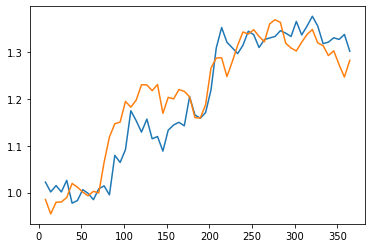

In [5]:
# check to make sure that there is a detectable increase in PHAkt reporter in cells

all_D_normed_filtered = []
pass_filter = []

for j in range(len(all_D)):
    i = all_D[j]
    global_normed_dynamics = i/np.average(i[:10])
    if np.average(global_normed_dynamics[20:]) > 1.05:
        all_D_normed_filtered.append(global_normed_dynamics)
        pass_filter.append(True)
    else:
        pass_filter.append(False)


L_filtered = []
R_filtered = []

for j in range(len(all_D)):
    i = all_D[j]
    global_normed_dynamics = i/np.average(i[:10])
    if np.average(global_normed_dynamics[20:]) > 1.05:

        L_filtered.append(all_L[j])
        R_filtered.append(all_R[j])
        
m1 = np.average(L_filtered, axis = 0)
m2 = np.average(R_filtered, axis = 0)

plt.plot(a.ch1_times[1:-1], m1)
plt.plot(a.ch1_times[1:-1], m2)

62.6


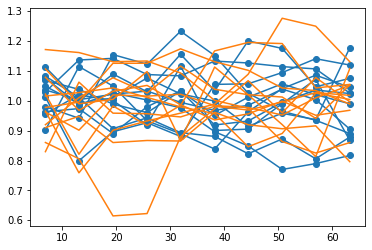

31.299999999999997


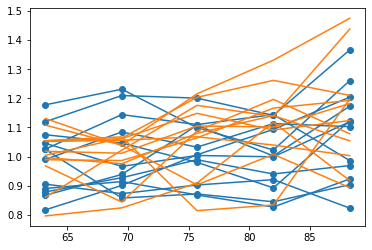

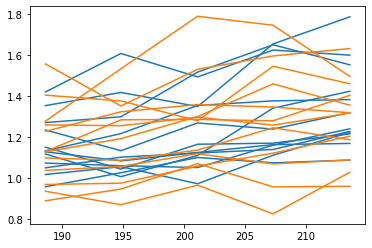

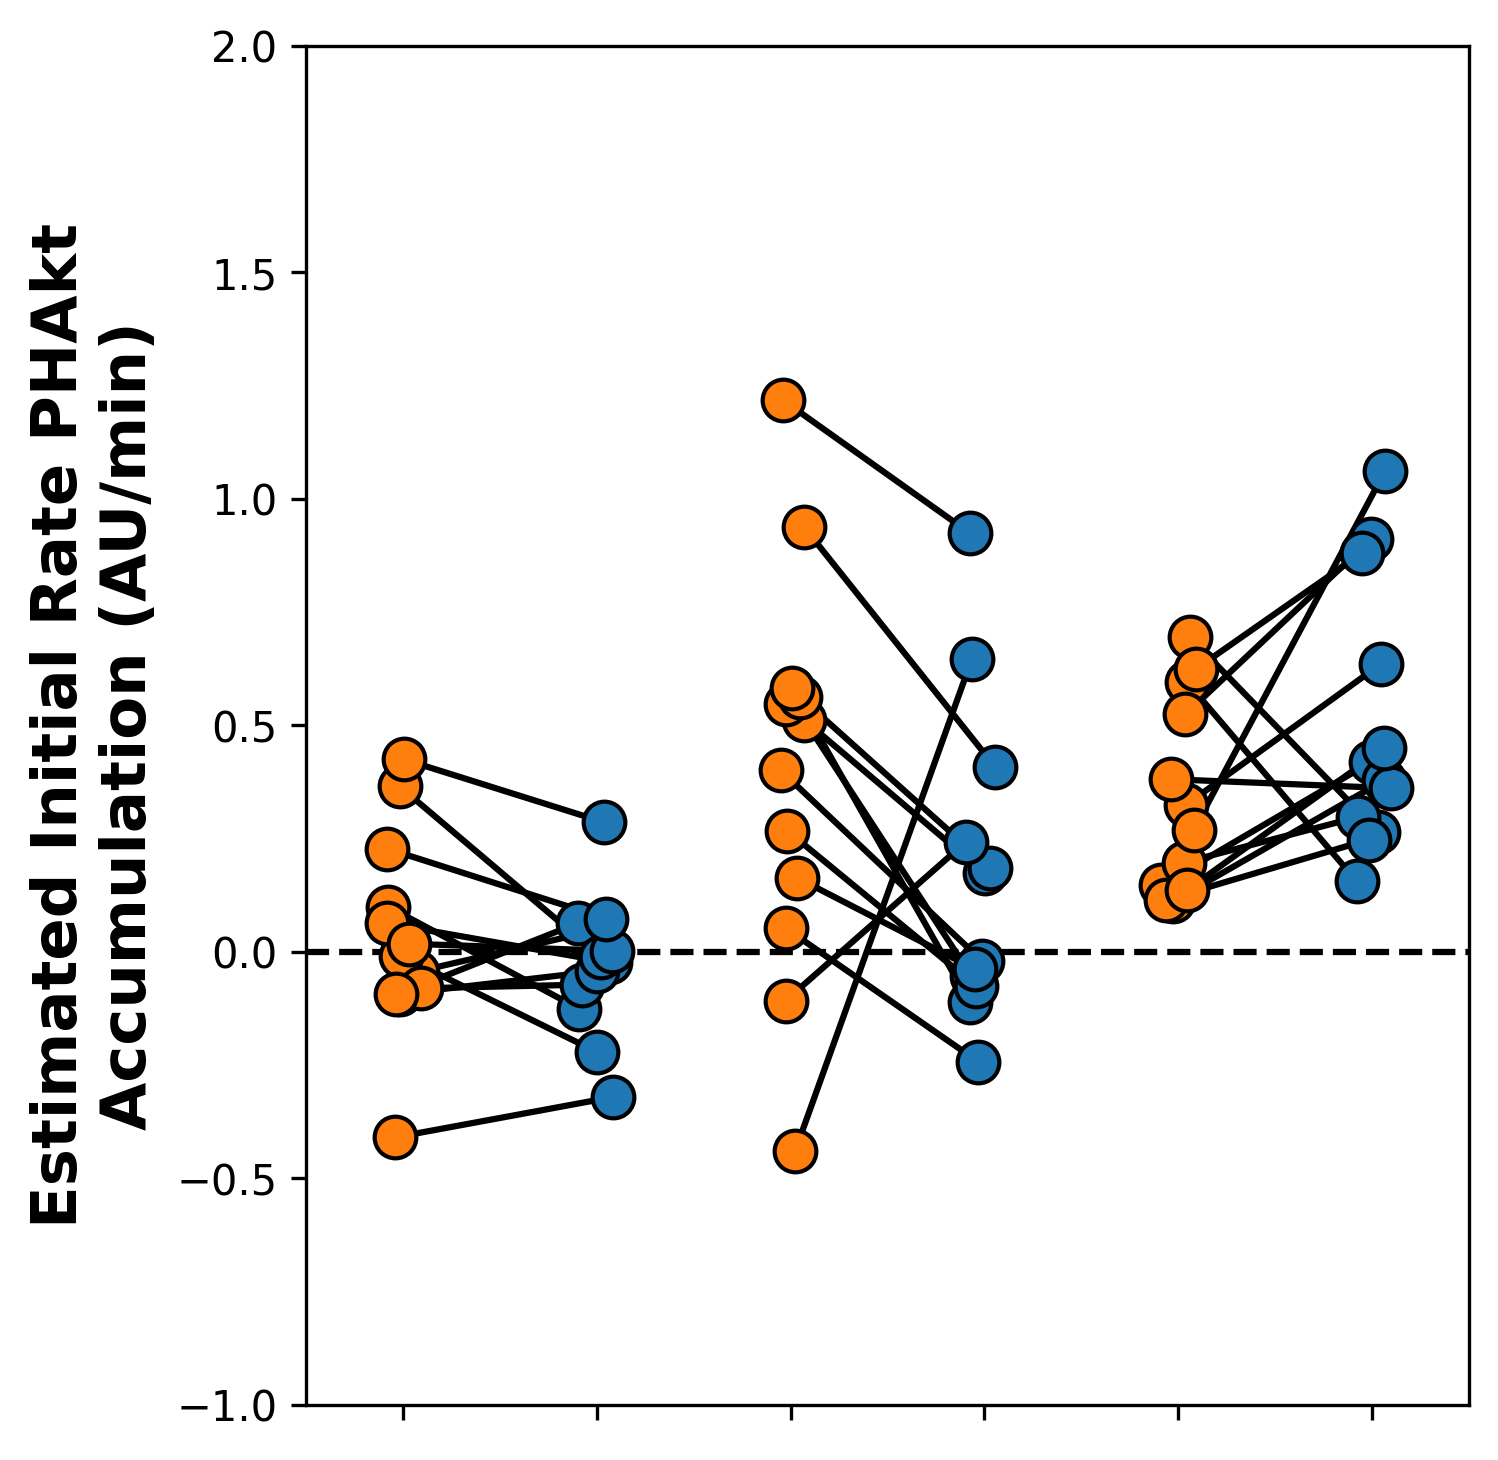

In [6]:

T = a.ch0_times[1:-1]

L_prestim_slope = []
R_prestim_slope = []
L_init_slope = []
R_init_slope = []
L_glob_slope = []
R_glob_slope = []



s, e = 0, 10
print(T[e] - T[s])
for i in L_filtered:
    plt.plot(T[s:e], i[s:e], color = 'C0', marker = 'o')
    reg = stats.linregress(T[s:e], i[s:e])
    L_prestim_slope.append(reg.slope)

for i in R_filtered:
    plt.plot(T[s:e], i[s:e], color = 'C1')
    reg = stats.linregress(T[s:e], i[s:e])
    R_prestim_slope.append(reg.slope)
    
plt.show()


s, e = 9, 14
print(T[e] - T[s])
for i in L_filtered:
    plt.plot(T[s:e], i[s:e], color = 'C0', marker = 'o')
    reg = stats.linregress(T[s:e], i[s:e])
    L_init_slope.append(reg.slope)
    
for i in R_filtered:
    plt.plot(T[s:e], i[s:e], color = 'C1')
    reg = stats.linregress(T[s:e], i[s:e])
    R_init_slope.append(reg.slope)

plt.show()

s, e = 29, 34
for i in L_filtered:
    plt.plot(T[s:e], i[s:e], color = 'C0')
    reg = stats.linregress(T[s:e], i[s:e])
    L_glob_slope.append(reg.slope)

for i in R_filtered:
    plt.plot(T[s:e], i[s:e], color = 'C1')
    reg = stats.linregress(T[s:e], i[s:e])
    R_glob_slope.append(reg.slope)

plt.show()



N = 0.2


x1 = np.zeros_like(R_init_slope)+N*np.random.random(len(R_init_slope)) - N/2. + 0
x2 = np.zeros_like(R_init_slope)+N*np.random.random(len(L_init_slope)) - N/2. + 1 
x3 = np.zeros_like(R_init_slope)+N*np.random.random(len(R_glob_slope)) - N/2. + 2
x4 = np.zeros_like(R_init_slope)+N*np.random.random(len(L_glob_slope)) - N/2. + 3
x5 = np.zeros_like(R_init_slope)+N*np.random.random(len(L_prestim_slope)) - N/2. + 4
x6 = np.zeros_like(R_init_slope)+N*np.random.random(len(R_prestim_slope)) - N/2. + 5

y1 = 60*np.array(R_prestim_slope)
y2 = 60*np.array(L_prestim_slope)
y3 = 60*np.array(R_init_slope)
y4 = 60*np.array(L_init_slope)
y5 = 60*np.array(R_glob_slope)
y6 = 60*np.array(L_glob_slope)

plt.figure(figsize = (5,6), dpi = 300)



plt.scatter(x1, y1, zorder = 1, c = 'C1', ec = 'k', s = 100)
plt.scatter(x2, y2, zorder = 1, c = 'C0', ec = 'k', s = 100)
plt.plot([x1, x2], [y1, y2], zorder = -1, color = 'k')

plt.scatter(x3, y3, zorder = 1, c = 'C1', ec = 'k', s = 100)
plt.scatter(x4, y4, zorder = 1, c = 'C0', ec = 'k', s = 100)
plt.plot([x3, x4], [y3, y4], zorder = -1, color = 'k')

plt.scatter(x5, y5, zorder = 1, c = 'C1', ec = 'k', s = 100)
plt.scatter(x6, y6, zorder = 1, c = 'C0', ec = 'k', s = 100)
plt.plot([x5, x6], [y5, y6], zorder = -1, color = 'k')


plt.xlim(-.5, 5.5)
plt.ylim(-1, 2)
plt.axhline(0, ls = '--', color = 'k', zorder = -1)

plt.xticks(range(6), ['','','','','',''])#['Naive Edge\nLocal Rate', 'Prestim Edge\nLocal Rate', 'Naive Edge\nGlobal Rate', 'Prestim Edge\nGlobal Rate'], fontweight = 'bold')
plt.ylabel('Estimated Initial Rate PHAkt\nAccumulation (AU/min)', fontweight = 'bold', fontsize = 15)

plt.show()